# SPRINT S8.01. Visualitzacions en Python

Aquesta pràctica permetrà explorar com es poden utilitzar eines de visualització avançades en Python per a interpretar i presentar dades de manera efectiva, proporcionant una oportunitat valuosa per a millorar les habilitats analítiques i tècniques.

## NIVELL 1

*Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.*

*Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.*

Abans de començar la importació de la nostra base de dades és necessari instal·lar alguns paquets i biblioteques de Python que ens permeten treballar amb dataframes i amb visualitzacions. 

In [1]:
#!pip install pymysql
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install datetime
#!pip install plotly-express

Un cop finalitzada la instal.lació, importem les biblioteques que farem servir al llarg de l'Sprint. 

In [2]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import datetime
from datetime import datetime

Per a realitzar la connexió entre MySQL i Python, hem de referenciar les dades personals del nostre host i user a MySQL mitjançant la funció .connect del connector PyMySQL. Posteriorment, creem un cursor que ens permetrà importar les taules de la base de dades enmagatzemada a MySQL. Gràcies a la funció fetchall del cursor podem extreure les diferents taules de la base de dades fent servir un bucle. A més, per a que Python guardi les taules, creem un diccionari buit amb el nom de dataframes que omplim mitjançant un segon bucle que ens carrega les taules com a dataframe de pandas. Aquesta integració entre pandas i el cursor s'ha pogut executar gràcies als moduls integrats de SQLAlchemy per a Pandas (és una funcionalitat que no conté la llibreria PyMySQL). Per assegurar-nos que les taules han estat carregades amb èxit, hem creat un missatge d'impressió que ens mostra el nom de cadascuna de les taules extretes amb el bucle i incloses al diccionari. Per últim, tanquem el cursor i la conexió amb MySQL. 

In [3]:
# Conectar a la base de datos
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='Gael2023',
    database='sales'
)

cursor = connection.cursor()
cursor.execute("SHOW TABLES")
tabla = [t[0] for t in cursor.fetchall()]

#Modifiquem el nom de dataframes a datasets per a no tenir incompatibilitats de nomenclatura amb PowerBI
dataframes = {}

for nombre_tabla in tabla:
    df = pd.read_sql_query(f"SELECT * FROM {nombre_tabla}", connection)
    dataframes[nombre_tabla] = df
    print(f"Tabla {nombre_tabla} cargada exitosamente.")

cursor.close()
connection.close()

Tabla cards_status cargada exitosamente.
Tabla companies cargada exitosamente.
Tabla credit_card cargada exitosamente.
Tabla products cargada exitosamente.
Tabla products_numbers cargada exitosamente.
Tabla transactions cargada exitosamente.
Tabla users cargada exitosamente.


C:\Users\Cristina\AppData\Local\Temp\ipykernel_12588\554148663.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(f"SELECT * FROM {nombre_tabla}", connection)


Posteriorment, hem d'extreure les taules del diccionari per a poder operar amb elles: 
- Recuperem les dades de la taula de fets mitjançant el diccionari de dataframes
- Extreiem les taules de dimensions que necessitem per a realitzar l'anàlisi
- Recuperem la taula pont del diccionari dataframes

In [4]:
df_transactions = dataframes['transactions']
df_products = dataframes['products']
df_users = dataframes['users']
df_prod_numbers = dataframes['products_numbers']

### Exercici 1: Una variable numèrica.


Per a començar l'anàlisi fem una breu exploració de la taula de fets. 

In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           587 non-null    object        
 1   card_id      587 non-null    object        
 2   business_id  587 non-null    object        
 3   timestamp    587 non-null    datetime64[ns]
 4   amount       587 non-null    float64       
 5   declined     587 non-null    int64         
 6   products_id  587 non-null    object        
 7   user_id      587 non-null    int64         
 8   lat          587 non-null    float64       
 9   longitude    587 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 46.0+ KB


Per a realitzar aquest exercici com un anàlisi cohessionat que ens ofereixi informació valuosa que encara no hem explorat en els anàlisis previs mitjançant els sprints de SQL i PowerBI, hem escollit realitzar una <b>anàlisi de producte</b> emprant les dades registrades a les taules de transaccions, taula pont de products_numbers i a la taula de dimensions de products. Considerem que aquesta anàlisi ens pot proporcionar un nou angle per a prendre decisions respecte a optimitzar l'activitat de la nostra empresa. 

Comencem l'anàlisi explorant la taula de dimensions 'products'.

In [6]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            100 non-null    object 
 1   product_name  100 non-null    object 
 2   price         100 non-null    object 
 3   colour        100 non-null    object 
 4   weight        100 non-null    float64
 5   warehouse_id  100 non-null    object 
dtypes: float64(1), object(5)
memory usage: 4.8+ KB


Com volem treballar amb les quantitats assolides a partir dels imports de venda dels productes, necessitem convertir aquesta dada que havíem enmagatzemat a SQL com a string en integrer, per tant, creem una funció que ens permet convertir el preu. 

In [7]:
def convertir_price(price_str):
    price_nosymbol = price_str.replace('$', '').replace(',', '')
    return float(price_nosymbol)

df_products['price'] = df_products['price'].apply(convertir_price)
print(df_products['price'])

0     161.11
1     119.52
2      40.43
3      49.70
4     181.60
       ...  
95      6.90
96     20.92
97     65.25
98     38.33
99    151.78
Name: price, Length: 100, dtype: float64


<b>Variable numèrica</b>: Preu dels diferents productes del catàleg de productes

In [8]:
df_products['price'].value_counts()

price
161.11    1
2.12      1
9.46      1
158.29    1
114.09    1
         ..
96.22     1
107.17    1
128.48    1
127.09    1
151.78    1
Name: count, Length: 100, dtype: int64

Configurem la variable per a representar-la per mitjà d'una visualització. 

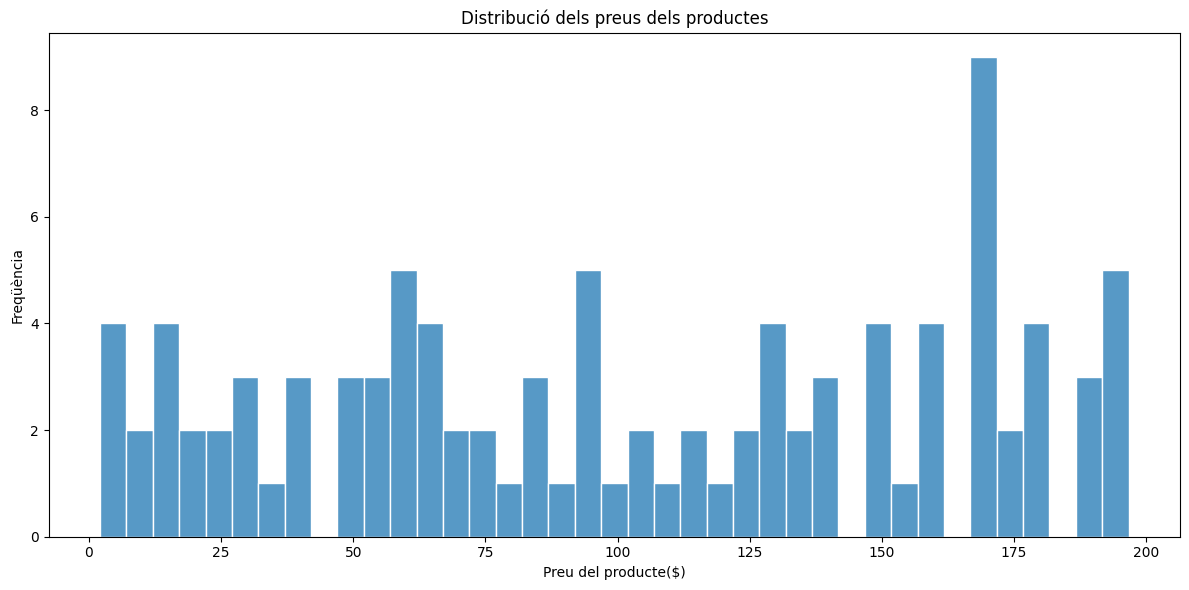

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_products, x='price', binwidth=5, edgecolor='white')
plt.title('Distribució dels preus dels productes')
plt.xlabel('Preu del producte($)')
plt.ylabel('Freqüència')
plt.tight_layout()
plt.show()

#### ANÀLISI DEL GRÀFIC

Aquest gràfic ens mostra una distribució irregular dels preus. Observem que el rang de preus del nostre catàleg de productes oscila entre els 3 i els 195€. Podem observar com la moda de preus és entre 165-170€, ja que hi ha una freqüència més gran de productes (9 productes). 

També trobem 5 productes en els rangs de 60-65€, 95€ i 195€. L'elecció d'aquests preus per a aquests productes pot respondre a una estratègia d'establir preu psicològic per a incitar en el consumidor la percepció de que estan pagant un preu més baix (per exemple existeix la percepció de que preus entorn els 90€ són molt més baixo que un cop superat els 100€). Això es deu a la tendència del consumidor de llegir els preus en dígits, per tant, un preu amb menys digits simbolitza psicològicament un preu inferior. 

Tanmateix la distribució de preus en un rang tan ampli (0-200€) ens indica que el nostre catàleg pretén arribar a consumidors que cerquen productes de baix preu però també aquells que tenen un poder adquisitiu major i poden comprar productes de preu unitari fins 200€. Ens cal, però analitzar quins són els productes dins del catàleg que més es venen i els seus respectius preus.


### Exercici 2 : Dues variables numèriques.

Creem una nova taula que presenti tots els registres corresponents a cada producte comprat a cadascuna de les transaccions.

In [10]:
df_prod_trans = pd.merge(df_transactions, df_prod_numbers, left_on='id', right_on='transaction_id', how='left')
df_prod_trans.head()

,id,card_id,business_id,timestamp,amount,declined,products_id_x,user_id,lat,longitude,products_id_y,transaction_id
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,71,02C6201E-D90A-1859-B4EE-88D2986D3B02
1,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,19,02C6201E-D90A-1859-B4EE-88D2986D3B02
2,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,1,02C6201E-D90A-1859-B4EE-88D2986D3B02
3,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,97,0466A42E-47CF-8D24-FD01-C0B689713128
4,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,47,0466A42E-47CF-8D24-FD01-C0B689713128


Per a treballar sobre els productes venuts, hem elaborat un nou dataframe que agrupi tots els productes que apareixien com a llistat en el registre de les transaccions gràcies a les dades de la taula pont. Aquest nou dataframe filtra les transaccions eliminant aquelles que han estat declinades, per a no tenir en compte els productes retornats. 

In [11]:
df_prod_sold = pd.merge(df_prod_trans[df_prod_trans['declined']==0], df_products, left_on='products_id_y', right_on='id', how='inner')
df_prod_sold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_x            1236 non-null   object        
 1   card_id         1236 non-null   object        
 2   business_id     1236 non-null   object        
 3   timestamp       1236 non-null   datetime64[ns]
 4   amount          1236 non-null   float64       
 5   declined        1236 non-null   int64         
 6   products_id_x   1236 non-null   object        
 7   user_id         1236 non-null   int64         
 8   lat             1236 non-null   float64       
 9   longitude       1236 non-null   float64       
 10  products_id_y   1236 non-null   object        
 11  transaction_id  1236 non-null   object        
 12  id_y            1236 non-null   object        
 13  product_name    1236 non-null   object        
 14  price           1236 non-null   float64       
 15  colo

<b>Variable numèrica 1</b>: Quantitat de productes venuts

In [12]:
count_prod = df_prod_sold['id_y'].value_counts().reset_index()
print(count_prod)

   id_y  count
0    23     60
1    67     59
2     2     56
3    43     54
4    17     54
5    97     53
6    79     52
7    13     51
8     1     51
9    47     50
10   61     50
11   41     48
12   53     47
13   83     46
14   89     46
15   37     45
16    7     44
17   19     44
18   71     44
19    3     43
20   29     43
21    5     42
22   11     40
23   31     40
24   73     39
25   59     35


In [13]:
count_prod.columns = ['id_y', 'count_prod']
df_prod_sold = df_prod_sold.merge(count_prod, on='id_y', how='left')

<b>Variable numèrica 2</b>: Preu del producte

In [14]:
df_prod_sold['price'].value_counts()

price
169.96    60
195.94    59
9.24      56
59.80     54
91.89     54
65.25     53
132.86    52
139.59    51
161.11    51
82.15     50
28.01     50
141.01    48
137.81    47
26.51     46
172.78    46
26.66     45
63.33     44
60.33     44
103.73    44
171.13    43
167.20    43
171.22    42
49.70     40
85.02     40
114.09    39
114.77    35
Name: count, dtype: int64

Grafiquem ambdues variables mitjançant un scatterplot ja que ens mostra la relació entre ambdues variables. 

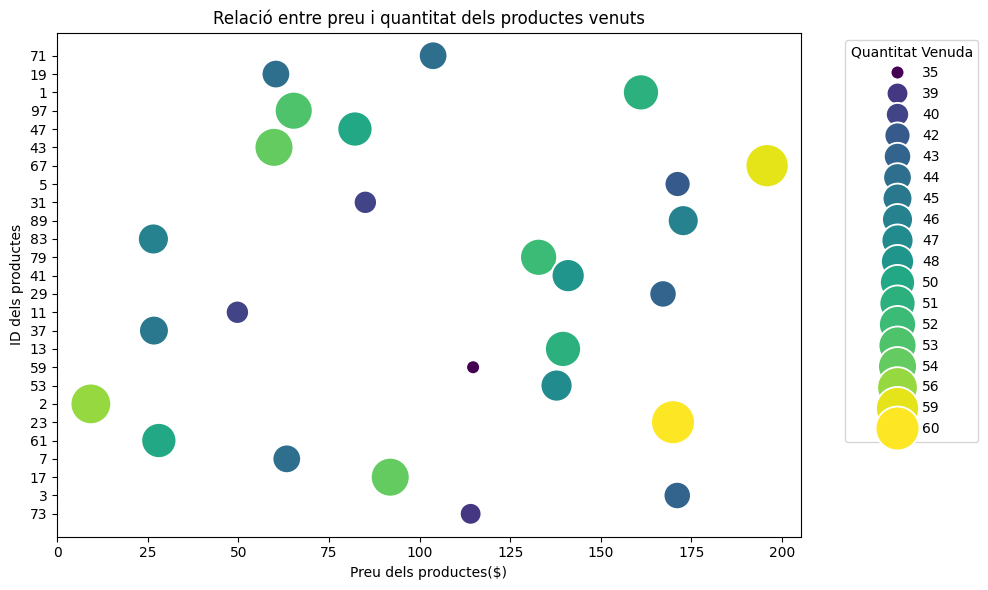

In [15]:
# Crear el scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_prod_sold, x='price', y='id_y', size='count_prod', sizes=(100, 1000), hue='count_prod', palette='viridis', legend='full')
plt.title('Relació entre preu i quantitat dels productes venuts')
plt.legend(title='Quantitat Venuda', bbox_to_anchor=(1.05, 1), loc='upper left')#, borderaxespad=0.)
plt.xlabel('Preu dels productes($)')
plt.ylabel('ID dels productes')
plt.tight_layout()
plt.show()

El gràfic anterior mostra els preus dels productes relacionats amb la quantitat de vegades que s'ha venut en un format de scatterplot. Per a realitzar aquesta anàlisi hem fet servir únicament els preus dels productes que han estat comprats. Hem triat les variables numériques de preu de producte i de vegades que s'ha venut, tot junt amb els IDs dels productes ja que mitjançant aquesta variable categòrica és més fàcil d'entendre les dades exposades al gràfic. 

#### ANÀLISI DEL GRÀFIC

Per mitjà del gràfic anterior observem com dels 100 productes que apareixien inicialment al nostre catàleg de 'productes' únicament s'estan venent 25. Aquesta informació ens pot ser d'utilitat si volem reduir el tamany del nostre catàleg i enfocar els nostres esforços de màrketing a un grup més reduït de productes per millorar les sinergies de producció i distribució. Cal considerar que el mínim que s'ha venut el producte menys venut del nostre catàleg ha estat 35 vegades. És significatiu que comptem amb 75 productes que mai s'han venut i que el primer producte venut hagi estat adquirit 35 vegades, per tant, caldria determinar si és convenient per a la nostra empresa mantenir els productes no venuts a catàleg. 

En segon lloc, observem com la variable preu no és determinant per a l'adquisició dels nostres productes. Alguns dels productes més venuts del nostre catàleg compten amb alguns dels preus més elevats (el producte més car s'ha comprat 59 vegades). Aquesta informació ens indica com el preu no és determinant per a l'adquisició dels nostres productes per part dels nostres consumidors. Per tant, podem jugar amb la flexibilitat dels preus per millorar els beneficis de la nostra empresa, ja que no comptem amb consumidors que es centrin en adquirir productes de baix cost sinó que hi ha una oscilació en els preus dels productes més venuts. 

### Exercici 3: Una variable categòrica.

Una variable categòrica que ens sembla necessària en fer l'anàlisi és els noms dels productes venuts. Aquesta dada ens facilita informació sobre quins productes s'estàn venent dins del nostre catàleg de productes. Tanmateix, en representar gràficament aquesta informació, hem optat per fer servir un countplot que ens ofereix un recompte de la nostra variable categòrica (una representació visual de la funció value_counts). 

<b>Variable categòrica:</b> Nom de productes venuts

In [16]:
df_prod_sold['product_name'].value_counts()

product_name
skywalker ewok                   88
Direwolf Stannis                 86
riverlands north                 60
Winterfell                       59
Tarly Stark                      56
skywalker ewok sith              54
duel                             54
jinn Winterfell                  53
Direwolf riverlands the          52
palpatine chewbacca              51
Winterfell Lannister             50
Tully                            50
Lannister Barratheon Direwolf    48
kingsblood Littlefinger the      47
duel tourney                     46
Direwolf Littlefinger            45
dooku solo                       44
north of Casterly                44
Tully Dorne                      44
duel tourney Lannister           43
Tully maester Tarly              43
Karstark Dorne                   40
Lannister                        40
Dorne bastard                    39
Name: count, dtype: int64

Per mitjà del countplot, visualitzem la nostra variable categòrica. 

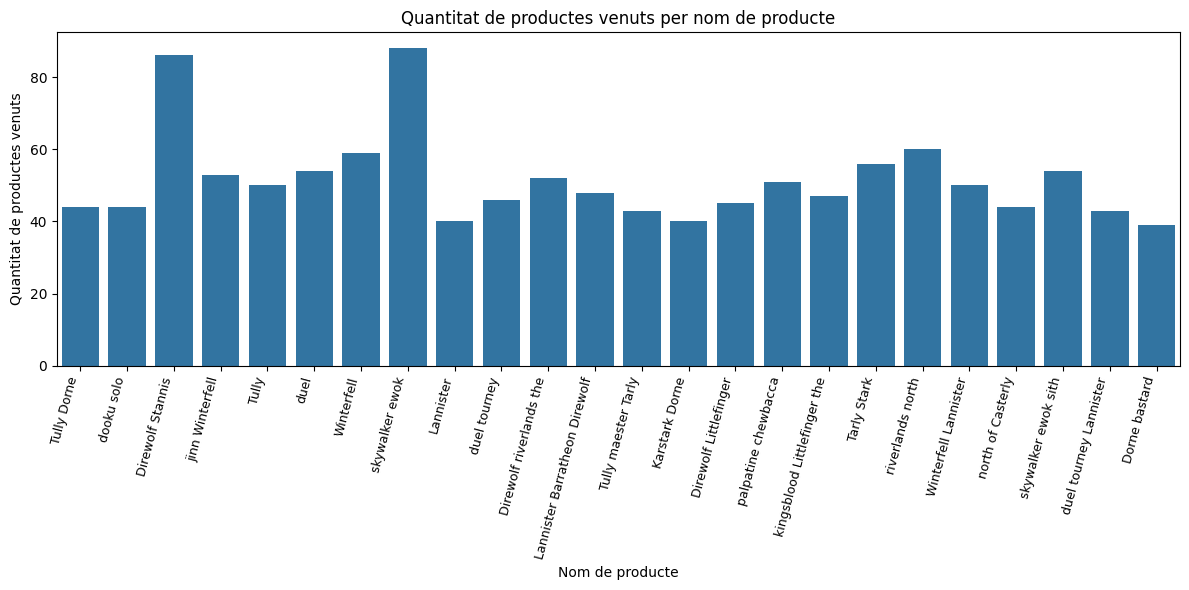

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_prod_sold, x='product_name')
plt.title('Quantitat de productes venuts per nom de producte')
plt.xlabel('Nom de producte')
plt.ylabel('Quantitat de productes venuts')
plt.xticks(rotation=75, ha='right', fontsize=9)
plt.tight_layout()  
plt.show()

#### ANÀLISI DEL GRÀFIC

Amb les dades d'aquest gràfic podem obtenir una primera impressió de quins productes s'estan venent més i de quins no estan apareixent en el recompte, per tant, no s'han venut. Observem que hi han 2 productes que destaquen sobre la resta (Direwolf Stannis i Skywalker Ewok), els nostres best-sellers. 
La informació recollida en aquest gràfic és d'utilitat per a campanyes de promoció de productes, per a recomenació de productes entre els clients que han comprat productes de la mateixa col·lecció-tipus i també per a descatalogar els productes que no han estat comprats i ens suposa un esforç econòmic la seva producció (en cas que hi existissin).

### Exercici 4: Una variable categòrica i una numèrica.

Creem la columna nova 'real_amount' a partir de la suma dels preus dels productes comprats en cada transacció. Amb aquesta nova variable podem conèixer el preu real que han pagat els consumidors en funció del valor del producte. Aquest amount és diferent del valor de les transaccions per tant, podríem considerar que les transaccions tenen altres conceptes dels quals no tenim dades, per exemple, descomptes, despeses de gestió, enviaments, etc. 

In [18]:
df_prod_sold['real_amount'] = df_prod_sold.groupby('id_x')['price'].transform('sum')

Preparem un nou dataframe amb la informació dels usuaris que han comprat productes a la nostra empresa.

In [19]:
df_buyers_info = pd.merge(df_prod_sold, df_users, left_on='user_id', right_on='id')

Creació d'un dataframe amb el preu real de la transacció per país on s'ubiquen els usuaris.

In [20]:
df_buyers = df_buyers_info.groupby('country')['real_amount'].sum().reset_index()
df_buyers

,country,real_amount
0,Canada,203364.23
1,United Kingdom,48120.96
2,United States,123595.45


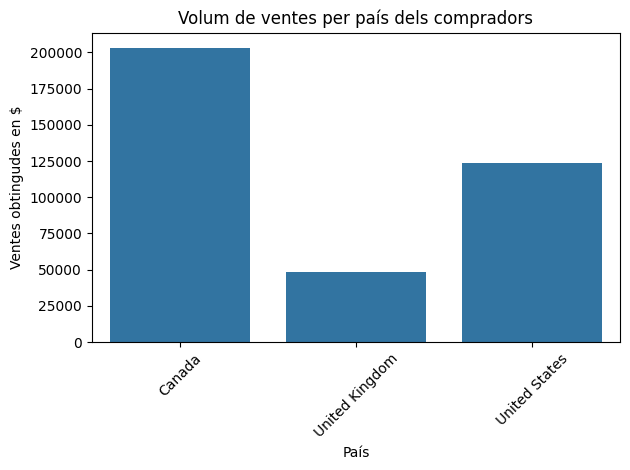

In [21]:
sns.barplot(data=df_buyers, x='country', y='real_amount')
plt.title('Volum de ventes per país dels compradors')
plt.xlabel('País')
plt.ylabel('Ventes obtingudes en $')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Aquest gràfic mostra la relació entre el total de vendes que s'han assolit en calcular les compres de cada producte segons el preu del producte, agrupades per país. Per a obtenir aquestes dades hem hagut de calcular el valor real de cada transacció en funció dels productes comprats en la mateixa i relacionar-lo amb el país on s'ubica l'usuari que ha realitzat cada transacció. Aquests valor real discrepa del valor 'amount' relatiu a la informació específica registrada per a cada transacció. Això ens denota que s'està aplicant qualsevol descompte, pagament per enviament de la comanda, IVA o qualsevol altre valor econòmic a la transacció que no es veu reflexat a la nostra base de dades. 

#### ANÀLISI DEL GRÀFIC

Observem que els nostres compradors es localitzen en 3 països principals: Canadà, Regne Unit i Estats Units. Tanmateix respecte al valor total de les vendes fetes, destaca notablement Canadà superant el 200.000$ en compres segons els preus registrats dels productes. Aquest país supera en gairebé 80.000$ el nostre segon mercat (Estats Units) i en més de 150.000$ al tercer mercat on s'ubiquen els nostres usuaris (Regne Unit). Per tant, cal dissenyar estratègies tant de fidelització com de captació al mercat canadenc on la nostra empresa està obtenint un major benefici. 

En el moment de l'anàlisi (2021-2022), Canadà és el segon país dels 3 mercats en poder adquisitiu, no obstant, les vendes obtingudes pels nostres productes mostren com la nostra empresa s'està consolidant en aquest mercat millor que en els altres 2. Una altra decisió que caldria considerar és impulsar campanyes publicitàries per al nostre públic objectiu a EEUU, principal mercat respecte a poder adquisitiu, per augmentar el nostre volum de vendes. 

Per últim, ja que aquestes vendes mostren únicament els beneficis obtinguts del preu de venda de cadascun dels productes, hauríem de ampliar la informació respecte als beneficis reals que ens suposa la venda dels nostres productes (enviament, logística, centres de distribució) per valorar si cal reforçar la captació de clients i promoció de productes al mercat britànic o no ens genera un marge de beneficis suficient per a aconseguir un elevat retorn de la inversió. 

### Exercici 5: Dues variables categòriques.

Per a elaborar aquest anàlisi, hem creat un nou dataframe amb els productes que han estat retornats. 

In [22]:
df_prod_returned = pd.merge(df_prod_trans[df_prod_trans['declined']==1], df_products, left_on='products_id_y', right_on='id', how='inner')
df_prod_returned.head()

,id_x,card_id,business_id,timestamp,amount,declined,products_id_x,user_id,lat,longitude,products_id_y,transaction_id,id_y,product_name,price,colour,weight,warehouse_id
0,07A46D48-31A3-7E87-65B9-0DA902AD109F,CcU-3225,b-2386,2021-06-28 21:11:42,340.87,1,"47, 23",272,38.8342,92.1905,47,07A46D48-31A3-7E87-65B9-0DA902AD109F,47,Tully,82.15,#919191,2.7,WH--42
1,07A46D48-31A3-7E87-65B9-0DA902AD109F,CcU-3225,b-2386,2021-06-28 21:11:42,340.87,1,"47, 23",272,38.8342,92.1905,23,07A46D48-31A3-7E87-65B9-0DA902AD109F,23,riverlands north,169.96,#545454,2.7,WH--18
2,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,CcU-3071,b-2298,2021-05-11 20:40:06,303.05,1,"67, 7",275,71.1706,10.5757,7,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,7,north of Casterly,63.33,#b7b7b7,0.6,WH--2
3,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,CcU-3071,b-2298,2021-05-11 20:40:06,303.05,1,"67, 7",275,71.1706,10.5757,67,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,67,Winterfell,195.94,#1c1c1c,0.6,WH--62
4,0BEB80B7-9D66-1707-CE4B-9DC7E71914B5,CcU-3141,b-2338,2022-03-04 14:54:35,288.81,1,"19, 41, 29, 3",272,23.3264,-13.6037,41,0BEB80B7-9D66-1707-CE4B-9DC7E71914B5,41,Lannister Barratheon Direwolf,141.01,#fcfcfc,3.2,WH--36


<b>Variable categòrica 1:</b> Nom de productes més retornats

In [23]:
prod_returned = df_prod_returned.groupby(['product_name']).size().reset_index(name='returned')

<b>Variable categòrica 2:</b> Nom de productes més venuts

In [24]:
prod_sold = df_prod_sold['product_name'].value_counts().reset_index(name='sold')
prod_sold.columns = ['product_name', 'sold']

Creem un dataframe conjunt que ens permeti mostrar al gràfic la comparativa entre ambdues variables.

In [25]:
df_combined = pd.merge(prod_returned, prod_sold, on='product_name', how='outer').fillna(0)
df_combined

,product_name,returned,sold
0,Direwolf Littlefinger,6,45
1,Direwolf Stannis,20,86
2,Direwolf riverlands the,14,52
3,Dorne bastard,8,39
4,Karstark Dorne,8,40
5,Lannister,7,40
6,Lannister Barratheon Direwolf,5,48
7,Tarly Stark,9,56
8,Tully,12,50
9,Tully Dorne,10,44


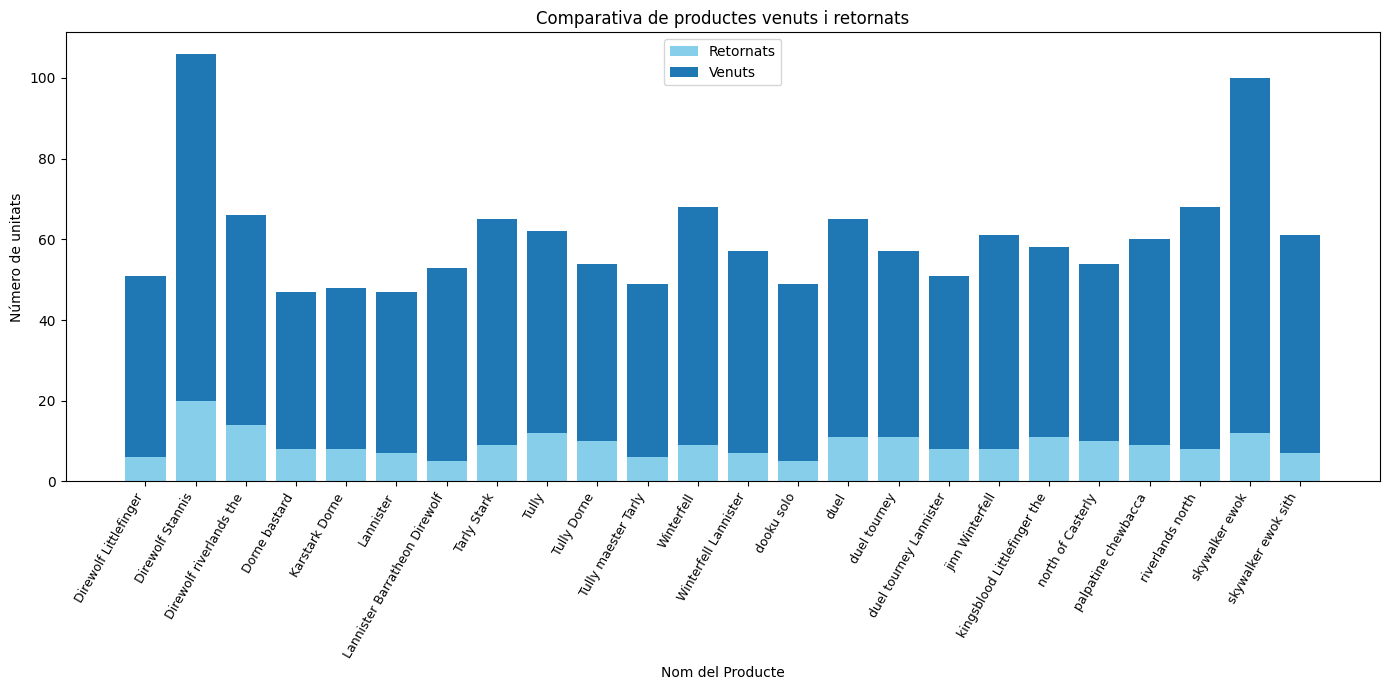

In [26]:
fig, ax = plt.subplots(figsize=(14, 7))
x = range(len(df_combined['product_name']))
ax.bar(x, df_combined['returned'], label='Retornats', color='skyblue')
ax.bar(x, df_combined['sold'], label='Venuts', bottom=df_combined['returned'])
ax.set_title('Comparativa de productes venuts i retornats')
ax.set_xlabel('Nom del Producte')
ax.set_ylabel('Número de unitats')
ax.set_xticks(x)
ax.set_xticklabels(df_combined['product_name'], rotation=60, fontsize=9, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Aquest gràfic ens mostra els productes més venuts d'una forma molt evident -semblant a la visualització de l'exercici 3 on es recollia la quantitat de productes venuts-, però al afegir les dades relatives als productes retornats, podem establir relacions entre els productes més venuts i més retornats. Hem seleccionat les variables categòriques de nom de producte i de devolució, amb un recompte del nombre de vegades que s'han adquirit o retornat.

#### ANÀLISI DEL GRÀFIC
En analitzar aquest gràfic observem els dos productes més destacats en quantitat de vendes, que superen les 80 unitats, i les seves devolucions. El Direwolf Stannis arriva a gairebé 20 devolucions, mentres que els Skywalker Ewok s'ha retornat 10 vegades, sense destacar entre altres productes que es compren menys i també es retornen sovint com el Duel, Duel Tourney o el Direwolf Riverlands. 
Aquesta dada ens permet fer un control de qualitat dels productes que més es retornen. Podríem contactar amb els clients que han fet devolucions d'un determinat producte per a verificar el grau de satisfacció amb el producte, el perquè de la devolució, etc. A més, podem veure la relació entre productes que s'han venut poc i retornat molt per a determinar la viabilitat d'aquest producte o si hi ha alguna informació errònia que estem oferint per la qual els clients adquireixen aquest producte 'per error'. 

### Exercici 6: Tres variables.

Per a realitzar l'anàlisi a partir de 3 variables hem decidit establir un nou marc entre els productes venuts, la categoria de Best-Seller. Per a determinar els productes que considerem best-seller, hem tingut en compte els 5 productes més venuts. A més, ens sembla molt interessant determinar quins usuaris han comprat els 5 productes best-sellers en més d'una ocasió com a compradors recorrents dels productes destacats del nostre catàleg. 

In [27]:
# Variable categòrica 1. Best-sellers products (5 productes més venuts)
bestsellers = df_prod_sold['product_name'].value_counts().nlargest(5).index

#Variable categòrica 2. Usuaris que han comprat tots els best-sellers més de 1 vegada. 
bestsellers_df = df_prod_sold[df_prod_sold['product_name'].isin(bestsellers)]
user_product_counts = bestsellers_df.groupby(['product_name', 'user_id']).size().reset_index(name='num_compres')
recurrent_buyers = user_product_counts[user_product_counts['num_compres'] > 1]

user_best_seller_count = recurrent_buyers.groupby('user_id')['product_name'].nunique()
required_count = len(bestsellers)
final_users = user_best_seller_count[user_best_seller_count == required_count]
topbuyers = recurrent_buyers[recurrent_buyers['user_id'].isin(final_users.index)]
print(topbuyers)

         product_name  user_id  num_compres
2    Direwolf Stannis       92            6
3    Direwolf Stannis       96            4
30   Direwolf Stannis      210            4
53   Direwolf Stannis      267            7
56   Direwolf Stannis      272            4
61        Tarly Stark       92            2
63        Tarly Stark       96            4
85        Tarly Stark      210            2
98        Tarly Stark      267            4
100       Tarly Stark      272            4
106        Winterfell       92            7
108        Winterfell       96            2
128        Winterfell      210            3
138        Winterfell      267            6
139        Winterfell      272            3
146  riverlands north       92            4
147  riverlands north       96            3
170  riverlands north      210            3
180  riverlands north      267            3
181  riverlands north      272            8
188    skywalker ewok       92            7
190    skywalker ewok       96  

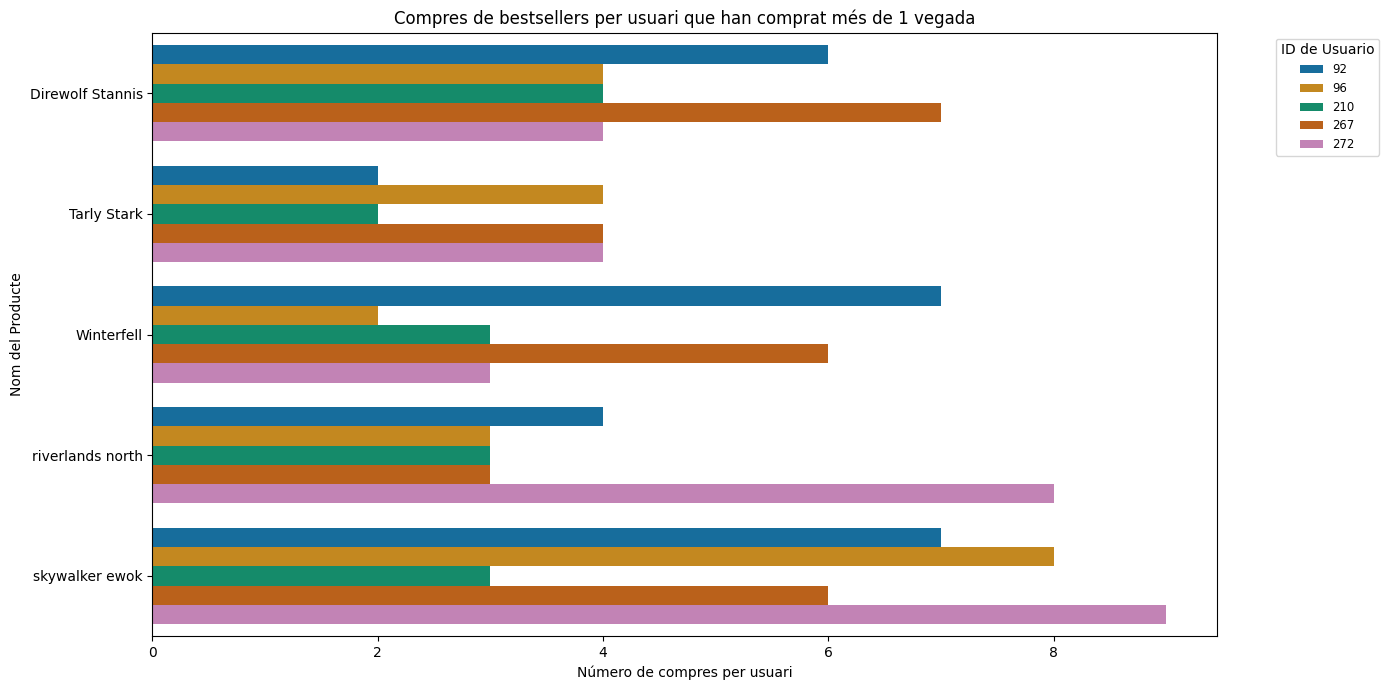

In [28]:
plt.figure(figsize=(14, 7))
sns.barplot(data=topbuyers, y='product_name', x='num_compres', hue='user_id', dodge=True, palette='colorblind')
plt.title('Compres de bestsellers per usuari que han comprat més de 1 vegada')
plt.ylabel('Nom del Producte')
plt.xlabel('Número de compres per usuari')
plt.legend(title='ID de Usuario', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

En elaborar aquest gràfic, hem considerat que el recompte seria una nova variable (num_compres), ja que determinem que el comptador de vegades que s'ha comprat un dels bestsellers ha de ser superior a 1. A més, hem presentat dues variables categòriques com el nom dels productes bestsellers i l' id dels usuaris que han comprat més d'un cop els 5 productes bestsellers (en aquest cas, són 5 usuaris). 

#### ANÀLISI DEL GRÀFIC
En analitzar el gràfic podem observar com hi han 5 usuaris (ID 92, 96, 210, 267, 272) que han adquirit tots els productes best-sellers en més d'una ocassió. Si observem desde la perspectva dels productes, cal destacar com dos usuaris (96, 272) han comprat el Skywalker Ewok en 8 i més ocasions, essent el producte que té una major compra reiterada d'entre els bestsellers. Però si el que pretenem és analitzar els usuaris, destaquen l'usuari ID 92 que ha adquirit en 7 ocassions el Tarly Stark i el Skywalker Ewok i l'usuari 272 que n'ha adquirit 9 vegades el Skywalker Ewok i en 8 el Riverlands north.

Aquesta informació pot ser valuosa de cara a fer un control de qualitat sobre els bestsellers i per a determinar a què és deguda la compra reiterada d'aquests productes. Per tant, des del departament de postvenda seria interessant contactar amb aquest usuaris per a conèixer el seu grau de satisfacció amb la venda i els productes. A més, aquest usuaris que han adquirit els nostres productes en repetides ocassions compten amb opinions sobre els processos de compra, els productes, la logística de l'empresa que es podria convertir en informació important per a millorar el nostre fluxe empresarial.

A més, com a compradors recorrents, podríem oferir descomptes a aquests clients per a mantenir la seva fidelització i convertir-los en promotors indirectes -si comparteixen reviews, opinions, etc- tant en la nostra web com en xarxes socials, ja que són clients que estan 'a priori' satisfets amb la nostra empresa. Iniciatives d'interacció amb els clients recurrents poden ajudar-nos a enfortir la nostra imatge de marca i crear sinergies en considerar-los com a promotors indirectes dels productes de la nostra empresa. 



### Exercici 7: Graficar un Pairplot.

Per a la creació del gràfic de Pairplot hem triat analitzar dues variable dins el dataframe de productes Bestsellers. Per a obtenir una nova relació entre les variables product_name i price, en aquest cas, hem cercat la relació amb una de les variables de productes que no havíem explorat: weight. Volem comprovar si hi ha cap relació entre preu i pes dels productes més venuts. 

In [29]:
bestsellers_df

,id_x,card_id,business_id,timestamp,amount,declined,products_id_x,user_id,lat,longitude,products_id_y,transaction_id,id_y,product_name,price,colour,weight,warehouse_id,count_prod,real_amount
2,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.91850,-12.5276,1,02C6201E-D90A-1859-B4EE-88D2986D3B02,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,51,325.17
6,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.22270,-129.0500,67,063FBA79-99EC-66FB-29F7-25726D1764A5,67,Winterfell,195.94,#1c1c1c,0.6,WH--62,59,534.33
7,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.22270,-129.0500,5,063FBA79-99EC-66FB-29F7-25726D1764A5,5,skywalker ewok,171.22,#dbdbdb,3.2,WH-0,42,534.33
10,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.35930,-100.5560,89,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,89,skywalker ewok,172.78,#636363,3.2,WH--84,46,332.15
21,1026DA24-8929-31F1-8250-D7BAB05C13D2,CcU-2959,b-2346,2021-12-07 09:30:38,465.31,0,"89, 11, 97, 79",92,32.06460,-140.1470,89,1026DA24-8929-31F1-8250-D7BAB05C13D2,89,skywalker ewok,172.78,#636363,3.2,WH--84,46,420.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,FCE2AB9A-271D-2BDC-9E49-8DD92A373391,CcU-4219,b-2302,2022-02-06 22:48:41,335.56,0,"59, 5, 41, 37",152,1.51316,48.2748,5,FCE2AB9A-271D-2BDC-9E49-8DD92A373391,5,skywalker ewok,171.22,#dbdbdb,3.2,WH-0,42,453.66
1225,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,CcU-3232,b-2390,2022-03-13 00:27:34,78.29,0,"83, 7, 17, 89",272,-24.31950,-11.4135,89,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,89,skywalker ewok,172.78,#636363,3.2,WH--84,46,354.51
1231,FD89D51B-AE8D-77DC-E450-B8083FBD3187,CcU-3960,b-2494,2022-03-16 02:35:05,200.72,0,"3, 2, 73, 1",250,8.01217,-64.6715,2,FD89D51B-AE8D-77DC-E450-B8083FBD3187,2,Tarly Stark,9.24,#919191,2.0,WH-3,56,455.57
1232,FD89D51B-AE8D-77DC-E450-B8083FBD3187,CcU-3960,b-2494,2022-03-16 02:35:05,200.72,0,"3, 2, 73, 1",250,8.01217,-64.6715,1,FD89D51B-AE8D-77DC-E450-B8083FBD3187,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4,51,455.57


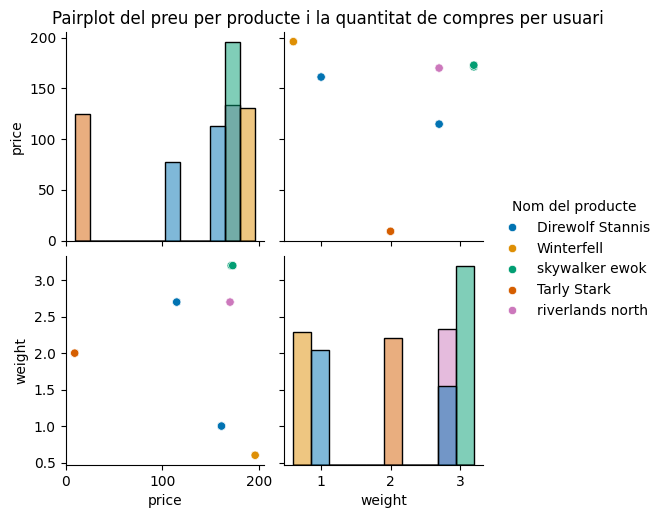

In [30]:
product_price = sns.pairplot(bestsellers_df, vars=['price', 'weight'], hue='product_name', palette='colorblind', diag_kind='hist')
product_price._legend.set_title('Nom del producte')
plt.suptitle('Pairplot del preu per producte i la quantitat de compres per usuari', y=1.02)
plt.show()

#### ANÀLISI DEL GRÀFIC

Aquest pairplot ens mostra la relació entre preu i pes dels productes bestsellers. Observem que el producte més car del nostre catàleg dins de la categoria 'Bestsellers' (Winterfell) té un dels preus més elevats i és relativament lleuger. Aquesta dada és interessant ja que és un producte que no ens suposa una despesa d'enviament tan gran com altres productes més pesats i, al mateix temps, ens dóna molts beneficis pel seu preu. 

D'altra banda, el producte més barat dins dels Bestsellers (Tarly Stark), té un pes mitjà. Caldria valorar si les despeses logístiques per a la seva distribució compensen el baix preu del producte. 

Cal destacar el producte Direwolf Stannis, el qual ens apareix com a un mateix producte amb característiques diferents (hi ha una diferència en pes i preu entre els dos models que presenta aquest producte). En aquest sentit cal valorar, quin dels dos models s'està venent més i cercar un preu o bé mitjà, o decantar-nos pel preu més elevat per tal d'obtenir més beneficis per a la nostra empresa sobre un producte que s'està venent molt. Igualment, cal analitzar les diferències en pes per tal d'acotar el preu amb la necessitat logística de distribució del producte per a obtenir el màxim benefici. 

Per últim, un altre producte que presenta dos valors diferenciats és Skywalker Ewok. La curiositat d'aquest producte és que ambdós models tenen unes característiques pràcticament iguals, per tant, caldría valorar la necessitat de produïr els dos models en relació a despeses logístiques. 

